In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams["axes.grid"] = False

In [2]:
ROOT_PATH = os.path.join('/Users/jacob/Projects/lane detection/')
os.chdir(ROOT_PATH)
frames_path = os.path.join(ROOT_PATH, 'frames/')

In [5]:
frames = os.listdir(frames_path)
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

In [6]:
images=[cv2.imread(frames_path+i) for i in frames]

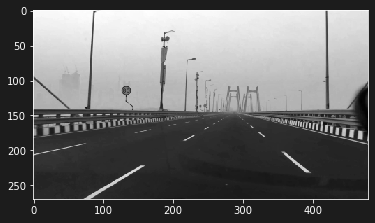

In [7]:
test_im = images[50][:,:,0]
plt.imshow(test_im, cmap="gray")

In [ ]:
stencil = np.zeros_like(test_im)
polygon = np.array([[50,270], [220,160], [360,160], [480,270]]) # [x, y]
cv2.fillConvexPoly(stencil, polygon, 1)
plt.imshow(stencil, cmap='gray')


In [ ]:
mask_im = cv2.bitwise_and(test_im, test_im, mask=stencil)
plt.imshow(mask_im, cmap='gray')

In [ ]:
ret, thresh = cv2.threshold(mask_im, 130, 145, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

# Perform Hough Transformation on masked image

In [ ]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
im_copy = test_im.copy()

In [ ]:
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(im_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)

In [ ]:
plt.imshow(im_copy, cmap='gray')

# Apply above all frames and output video

In [8]:
stencil = np.zeros_like(test_im)
polygon = np.array([[50,270], [220,160], [360,160], [480,270]]) # [x, y]
cv2.fillConvexPoly(stencil, polygon, 1)
detection_path = os.path.join(ROOT_PATH, 'detected')

if os.path.isdir(detection_path)==False:
    os.mkdir(detection_path)
    
for i, img in enumerate(images):
    im = img[:,:,0]
    masked = cv2.bitwise_and(im, im, mask=stencil)
    ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
    copy = img.copy()
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.imwrite('./detected/{}.png'.format(str(i)), copy)
    except TypeError:
        cv2.imwrite('./detected/{}.png'.format(str(i)), img)

In [9]:
# list of frame filenames
output_frames = [i for i in os.listdir(detection_path)
                 if os.path.isfile(os.path.join(detection_path, i))]
# sort list
output_frames.sort(key=lambda f: int(re.sub('\D', '', f)))
# load frames using sorted name list
loaded_frames = [cv2.imread(os.path.join(detection_path, i)) for i in output_frames]

In [27]:
res = (loaded_frames[0].shape[1], loaded_frames[0].shape[0]) # grab frame resolution
vid = cv2.VideoWriter('roads_output.mp4', cv2.VideoWriter.fourcc(*'DIVX'), 30, res) # init video

for fname in output_frames:
    f = cv2.imread(os.path.join(detection_path, fname))
    vid.write(f)
vid.release()